# **How BLUEbikes can encourage ridership through improving user experience** 

**Team 7: Jacob Elson, Laura Abadia Rodriguez, Salaal Malik, Seonghoon (Steve) Cho, Xi Wang**

---

# **1. Introduction**

####Problem Statement

Bike-sharing systems are becoming increasingly popular in urban environments since they provide a low-cost, environmentally-friendly transportation alternative for cities. BLUEbikes is the bike share program in Boston, with over 3,000 bikes and 300+ stations across the neighborhoods of  Arlington, Greater Boston, Brookline, Cambridge, Chelsea, Everett, Newton, Revere, Somerville, and Watertown. 

BLUEbikes offer a pleasant, affordable, and convenient transportation option for quick trips around town and offer its services to subscribers and non-subscribers.

Our analysis is based on the BLUEbikes usage data by customer type, operating hours, weekday and weekend trends, rush-hour and station usage in the greater Boston area. By analyzing the customer market of BLUEbikes, we hope to identify service gaps and improve the overall operations by optimizing station docking operations, bike distribution and assessing the need for a maintenance program. 

Chief among these problems is the issue of bicycle mal performance detection, upkeep, and maintenance; in this project, we tackle the problem of early identification of non-functioning bicycles and propose possible key optimization checkpoints for transportation maintenance.






####Data Structure
**The columns of the 'trip dataset' for each ride are outlined  below:**

**Column**|**Description**
---------|----------
Trip Duration| Length of trip in seconds
Start Time| Start time of trip hh:mm:ss
Stop Time| Stop time of trip hh:mm:ss
Start Station ID| Station's unique ID number
Start Staion Name| Start station's address
Start Station Latitude| Station's latitude coordinant
Start Station Longitude| Station's longitude coordinant
End Station ID| Station's unique ID number
End Station Name| End station's address
End Station Latitude| Station's latitude coordinant
End Station Longitude| Station's longitude coordinant
Bike ID| Bike's unique ID number
User Type| User's membership status('subscriber' or 'customer')
Birth Year| rider's birth year
Gender| Riders gender (0=unknown, 1=male, 2=female)

**The columns for the station dataset are outlined below:**

**Column**|**Description**
---------|----------
Number| Station ID number
Name| Station address
Latitude| Station's latitude
Longitude| Station's longitude
District| Neighborhood by zip code
Public| Yes or No (however all stations are currently public)
Total Docks| total dumber of docking stations for bikes at that location

**Source:**

**BLUEbikes** https://www.bluebikes.com/system-data

**The City of Boston - Citywide Bike Counts**
https://www.boston.gov/departments/boston-bikes/bike-data

#### Environment Setup

In [43]:
# loading google drive
from google.colab import drive
drive.mount('/content/gdrive')
# !ls /content/gdrive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [44]:
# set team folder and data folder path
team_drive_path = "/content/gdrive/Shareddrives/IS833_Team 7"
blue_bike_drive = "/content/gdrive/Shareddrives/IS833_Team 7/data/blue_bike"
city_of_boston_drive = "/content/gdrive/Shareddrives/IS833_Team 7/data/city_of_boston"
# !ls '/content/gdrive/Shareddrives/IS833_Team 7/data/blue_bike'

In [45]:
# import necessary libries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import datetime as dt
import pandas.util.testing as tm

%matplotlib inline

# import ML packages
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# set figure size
sns.set(rc={'figure.figsize': (12, 8)})

In [46]:
# data_year = np.arange(2015, 2021)
data_year = np.arange(2018, 2021)
data_month = np.arange(1, 13)

data_file = np.array([str(y) + '{:0>2s}'.format(str(m)) for y in data_year for m in data_month])

data_file_name = np.array([None]*len(data_file))

# set datafile name to read from drive
for i, f in enumerate(data_file):
    if str(f) > '201804':
        data_file_name[i] = str(f) +'-bluebikes-tripdata.csv'
    else:
        data_file_name[i] = str(f) +'-hubway-tripdata.csv'

# build full file path        
data_file_path = np.array([None]*len(data_file))
for i, f in enumerate(data_file_name):
    #print('i:{0}, f:{1}'.format(i, f))
    #print(type(f))
    data_file_path[i] = '/'.join([blue_bike_drive, f])

# read from each dataset file
data_file_df = np.array([None]*len(data_file))
for i, f in enumerate(data_file_path):
    try:
        data_file_df[i] = pd.read_csv(f)
        print('{0} read complete.'.format(f))
    except FileNotFoundError:
        data_file_df[i] = pd.read_csv(f.replace('-', '_'))
        print('{0} read complete.'.format(f))

# concaternate all the data we read
bb_trip = pd.concat(data_file_df)
bb_act = pd.concat(data_file_df)
bb_trip['age'] = 2021 - bb_trip['birth year'] 
bb_act['age'] = 2021 - bb_act['birth year'] 

print('There are {0} observations'.format(bb_trip.shape[0]))

/content/gdrive/Shareddrives/IS833_Team 7/data/blue_bike/201801-hubway-tripdata.csv read complete.
/content/gdrive/Shareddrives/IS833_Team 7/data/blue_bike/201802-hubway-tripdata.csv read complete.
/content/gdrive/Shareddrives/IS833_Team 7/data/blue_bike/201803-hubway-tripdata.csv read complete.
/content/gdrive/Shareddrives/IS833_Team 7/data/blue_bike/201804-hubway-tripdata.csv read complete.
/content/gdrive/Shareddrives/IS833_Team 7/data/blue_bike/201805-bluebikes-tripdata.csv read complete.
/content/gdrive/Shareddrives/IS833_Team 7/data/blue_bike/201806-bluebikes-tripdata.csv read complete.
/content/gdrive/Shareddrives/IS833_Team 7/data/blue_bike/201807-bluebikes-tripdata.csv read complete.
/content/gdrive/Shareddrives/IS833_Team 7/data/blue_bike/201808-bluebikes-tripdata.csv read complete.
/content/gdrive/Shareddrives/IS833_Team 7/data/blue_bike/201809-bluebikes-tripdata.csv read complete.
/content/gdrive/Shareddrives/IS833_Team 7/data/blue_bike/201810-bluebikes-tripdata.csv read co

In [47]:
station_file_name = 'current_bluebikes_stations.csv'
station_full_path = '/'.join([blue_bike_drive, station_file_name])

bb_station = pd.read_csv(station_full_path)



---



# **2. Statistical Data Analysis**

In [48]:
bb_trip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6364025 entries, 0 to 74001
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tripduration             int64  
 1   starttime                object 
 2   stoptime                 object 
 3   start station id         int64  
 4   start station name       object 
 5   start station latitude   float64
 6   start station longitude  float64
 7   end station id           int64  
 8   end station name         object 
 9   end station latitude     float64
 10  end station longitude    float64
 11  bikeid                   int64  
 12  usertype                 object 
 13  birth year               float64
 14  gender                   float64
 15  postal code              object 
 16  age                      float64
dtypes: float64(7), int64(4), object(6)
memory usage: 874.0+ MB


In [49]:
print('Total amount of users:',bb_trip['usertype'].count())
print('User type:',bb_trip['usertype'].unique())

Total amount of users: 6364025
User type: ['Subscriber' 'Customer']


In [50]:
#Convert `starttime` and `stoptime` to `datetime` for our further analysis
bb_trip['starttime'] = pd.to_datetime(bb_trip['starttime'])
bb_trip['stoptime'] = pd.to_datetime(bb_trip['stoptime'])

bb_trip['startdayofweek'] = bb_trip['starttime'].dt.dayofweek
bb_trip['starthour'] = bb_trip['starttime'].dt.hour


import holidays

us_holidays = holidays.UnitedStates()                              

bb_trip['holiday_name'] = bb_trip['starttime']
bb_trip['holiday_name'] = bb_trip['holiday_name'].apply(us_holidays.get)
bb_trip['is_holiday'] = bb_trip['holiday_name'].notna()

In [51]:
#For the convenience we define datetime houly aggrated bike trip counting dataframe.
bb_trip_hr = bb_trip.set_index('starttime').resample('H').count()[['bikeid']]
bb_trip_hr.index.name = 'timestamp'
bb_trip_hr.columns = ['count']
bb_trip_hr['year'] = bb_trip_hr.index.year
bb_trip_hr['month'] = bb_trip_hr.index.month
bb_trip_hr['day'] = bb_trip_hr.index.day
bb_trip_hr['day_name'] = bb_trip_hr.index.day_name
bb_trip_hr['hour'] = bb_trip_hr.index.hour
bb_trip_hr['dayofweek'] = bb_trip_hr.index.dayofweek

bb_trip_hr['season'] = ''
lst_m_to_season = {'spring': [3, 4, 5], 'summer': [6, 7, 8], 'fall': [9, 10, 11], 'winter': [12, 1, 2]}
for k, v in lst_m_to_season.items():
    bb_trip_hr.loc[bb_trip_hr.index.month.isin(v), 'season'] = k

bb_trip_hr.head()

,count,year,month,day,day_name,hour,dayofweek,season
timestamp,,,,,,,,
2018-01-01 00:00:00,4,2018,1,1,<bound method inherit_from_data.<locals>.metho...,0,0,winter
2018-01-01 01:00:00,6,2018,1,1,<bound method inherit_from_data.<locals>.metho...,1,0,winter
2018-01-01 02:00:00,6,2018,1,1,<bound method inherit_from_data.<locals>.metho...,2,0,winter
2018-01-01 03:00:00,0,2018,1,1,<bound method inherit_from_data.<locals>.metho...,3,0,winter
2018-01-01 04:00:00,0,2018,1,1,<bound method inherit_from_data.<locals>.metho...,4,0,winter


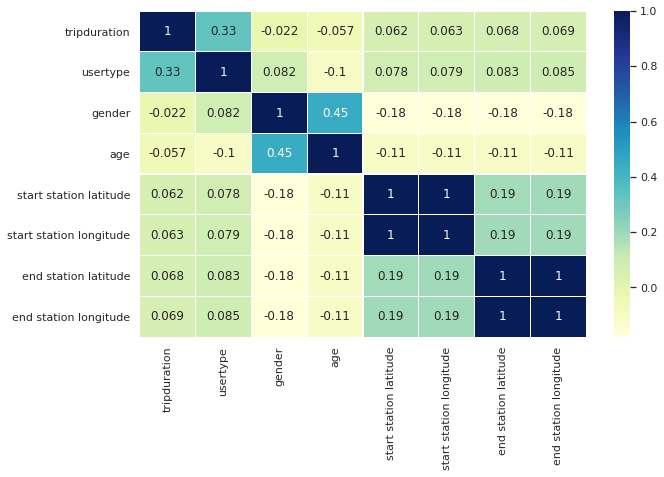

In [75]:
bb_corr = bb_trip[['tripduration', 'usertype', 'gender', 'age', 'start station latitude', 'start station longitude', 'end station latitude', 'end station longitude']]
plt.figure(figsize=(10, 6))
corr = bb_corr.apply(lambda x: pd.factorize(x)[0]).corr()
sns_plot = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu", annot=True)

To better understand what variables are correlated with the ridership, we plotted a heatmap with the Pearson correlation coefficient to further understand the relationships between data sets. We found a significant correlation between trip duration and user type. 



### 2.1 Data preprocessing

Bike-sharing systems have been introduced to major cities over the last decades; generally, they are a cost-effective way of promoting sustainable transportation in urban areas. BLUEbikes service consists of stations where customers can either take a single short trip for \$2.95, subscribe for 2-hour rides in the period of 24 hours for \$10, and monthly or annual subscriptions pass for \$109.

BLUEbikes then, by definition, can only be picked up and returned in Boston, Cambridge, Somerville, Brookline, and Everett; but users can ride them in other municipalities.
 

</font>

### 2.2 Exploratory Data Analysis

Our initial analysis is based on the critical metrics of usage, starting by observing large-scale monthly macrotrends from 2018 to 2021 to understand the business's cyclical nature. We also analyzed smaller scaler consumer microtrends and hourly trends to understand possible correlations with external factors. 

We used data visualization tools to get a deeper understanding of the operations management issues related to customer behaviors and fundamental system constraints.



### 2.2.1 Ridership over various timeframes

By analyzing BLUEbikes' usage data on Boston and the surrounding area, we hope to identify and address prevalent problems that BLUEbikes' users  face consistently while using the service. A primary problem we explored through the BLUEbikes dataset were instances of broken bikes, in which users began a ride, realize the bike was defective, and returned it to the dock.  These instances cause frustration and harm the users experience, particularly for customers without a membership who pay the per ride rate. 
 
To identify such instances, we sorted the data by ride length, then also sorted it by bike ID to identify the number of unique bikes that were used in multiple rides of less than 3 minutes. 
 
*It should also be noted that BLUEbikes' docking stations have a small wrench button on each dock’s keypad (where you enter the unlock code) that users may press when returning their bike to signify that it requires maintenance. Once pressed, the button locks that bike, so it cannot be rerented until it is inspected. For the scope of this inquiry, we are operating under the assumption that many if not most riders are unaware of this feature, and will just return their malfunctioning bikes, and those bikes are then rerented and returned by the next user.
  
By examining both the station and ridership datasets, we hope to uncover the above issues and derive a solution.
* Amount of bike shares vs date
(x=date, y=amount of bike shares)

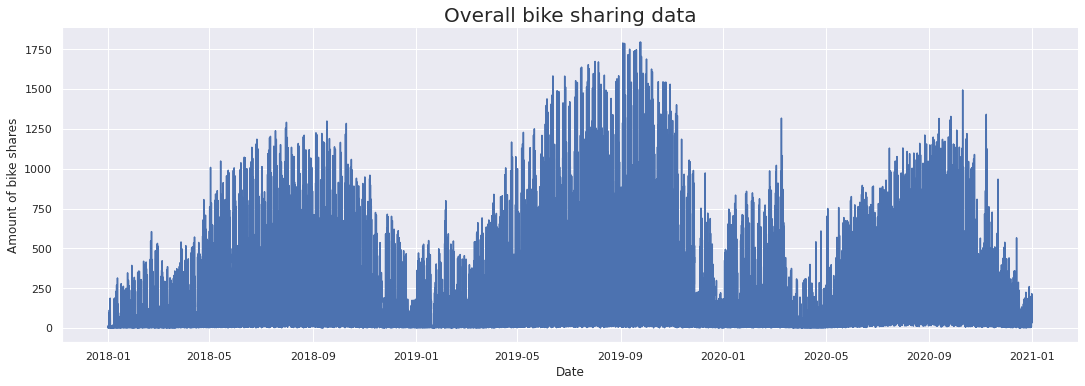

In [52]:
sns_plot = sns.relplot(x=bb_trip_hr.index, y='count', kind='line', data=bb_trip_hr, height=5, aspect=3);
plt.xlabel('Date');
plt.ylabel('Amount of bike shares');
plt.title('Overall bike sharing data', fontsize=20);
sns_plot.savefig("Overall bike sharing data.png")

To begin tackling how to analyze the usage data best, we plotted the amount of bike-share rides from January 2018 to January 2021. From these computations, we want to understand if there's a spike of usage during certain months and the service's cyclical nature and identify possible correlations with other variables, such as weather seasons, since BLUEbikes limits its operations during some winter months. 

In the plot, we can appreciate a spike in the number of bike shares in the months of May to October with a decrease in usage in the months of November to April. There's an apparent overall increase in use in the year 2019 compared to 2018 and 2020, which we will further analyze in other data plots.


### a. Amount of bike shares per month

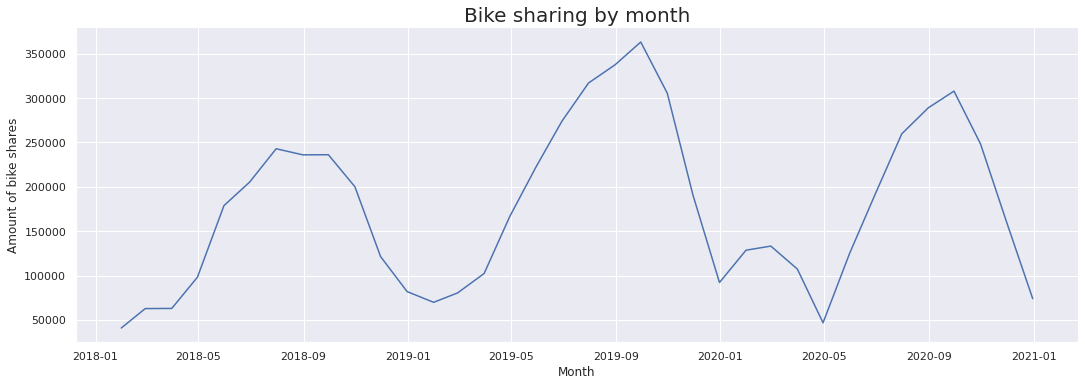

In [53]:
per_m_cnt = bb_trip_hr.resample('M').sum()
sns_plot = sns.relplot(x=per_m_cnt.index, y='count', kind='line', data=per_m_cnt, height=5, aspect=3);
plt.xlabel('Month')
plt.ylabel('Amount of bike shares');
plt.title('Bike sharing by month', fontsize=20);
#sns_plot.savefig("Bike sharing by month.png")



To get a better visual representation of the historical usage trends, we plotted the amount of bike-share rides from January of 2018 to January of 2021 by month. 

Something that caught our attention was the usage peak of October 2019, which could be associated with the most significant expansion of the BLUEbikes station; the system added 63 stations in 2019, including underserved areas like Mattapan, Rosindale, and Dorchester. 

Similarly, the covid-19 pandemic effect on quarantines, which substantially limited physical activities, making the BLUEbikes the perfect socially distancing activity and therefore explaining the surge in demand. 

The peak was followed by a steep decline in bike-share rides, with two bottoms in January and May 2020, respectively.



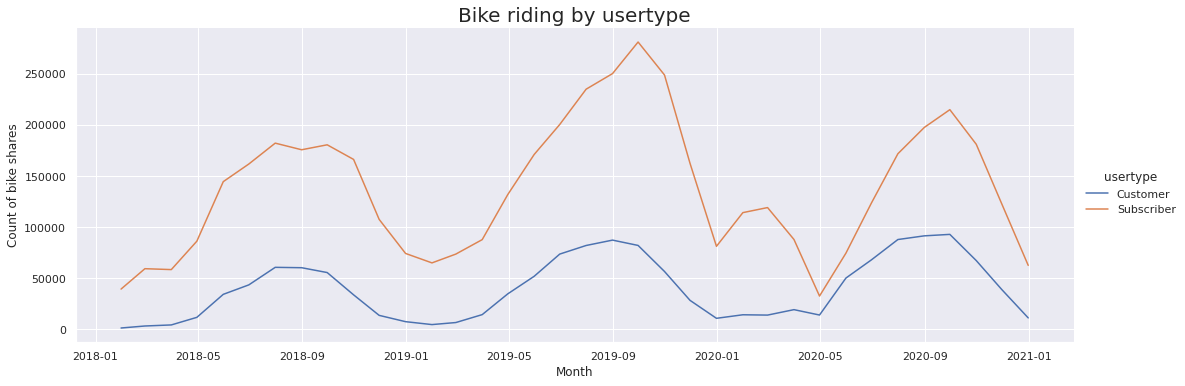

In [54]:
bb_trip_user_m = bb_trip.set_index('starttime').groupby('usertype').resample('M').count()
bb_trip_user_m = bb_trip_user_m[['bikeid']].rename({'bikeid': 'count'}, axis=1).reset_index()
sns_plot = sns.relplot(x='starttime', y='count', hue='usertype', kind='line', data=bb_trip_user_m, height=5, aspect=3);
plt.xlabel('Month')
plt.ylabel('Count of bike shares');
plt.title('Bike riding by usertype', fontsize=20);
#sns_plot.savefig("Bike riding by usertype.png")

### b. Amount of bike shares per day

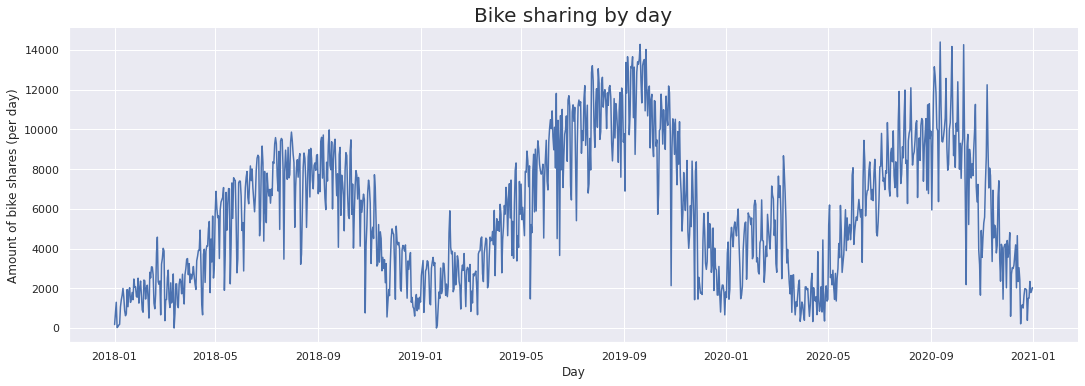

In [55]:
per_d_cnt = bb_trip_hr.resample('D').sum()
sns_plot = sns.relplot(x=per_d_cnt.index, y='count', kind='line', data=per_d_cnt, height=5, aspect=3, palette='YlGnBu');
plt.xlabel('Day');
plt.ylabel('Amount of bike shares (per day)');
plt.title('Bike sharing by day', fontsize=20);
#sns_plot.savefig("Bike sharing by day.png")

Once we got a general understanding of the usage trends by month and their historical peak and valleys, we plotted the amount of bike-share rides from January of 2018 to January of 2021 by day.

In this plot, we can appreciate the variance in usage between days; there are high ride frequency variations per day, even during peak months. This might indicate how volatile bike usage can be and, it might signal that multiple variables are related to the demand of bikes and customer behaviors.

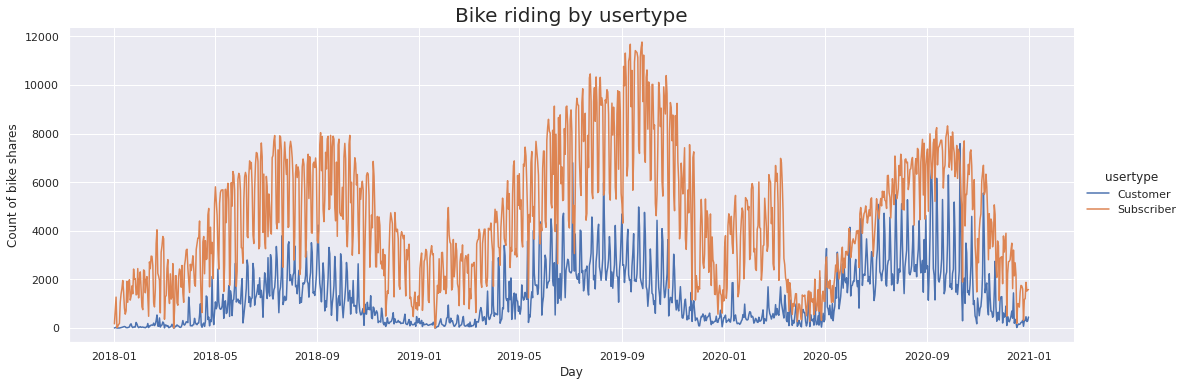

In [56]:
bb_trip_user_d = bb_trip.set_index('starttime').groupby('usertype').resample('D').count()
bb_trip_user_d = bb_trip_user_d[['bikeid']].rename({'bikeid': 'count'}, axis=1).reset_index()
sns_plot = sns.relplot(x='starttime', y='count', hue='usertype', kind='line', data=bb_trip_user_d, height=5, aspect=3);
plt.xlabel('Day')
plt.ylabel('Count of bike shares');
plt.title('Bike riding by usertype', fontsize=20);
#sns_plot.savefig("Bike riding by usertype.png")

### c. Amount of bike shares per season

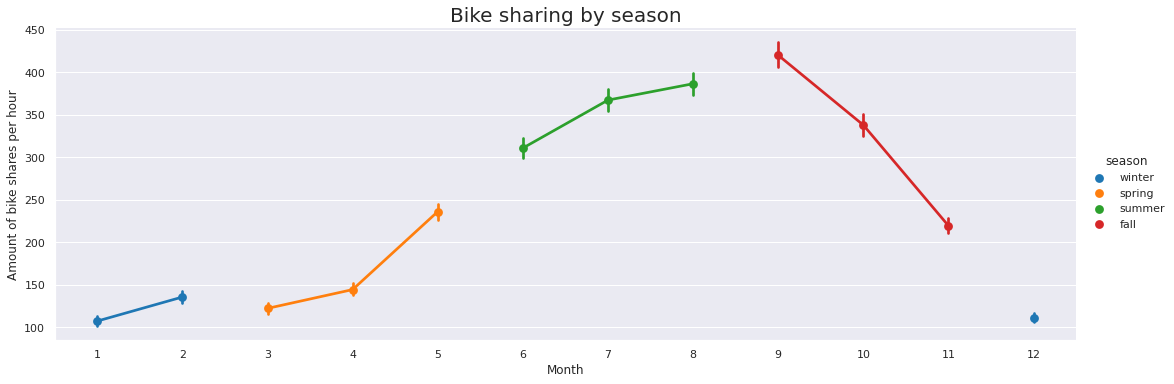

In [57]:
sns_plot = sns.catplot(x='month', y='count', hue='season', kind='point', data=bb_trip_hr, height=5, aspect=3, palette='tab10');
plt.xlabel('Month');
plt.ylabel('Amount of bike shares per hour');
plt.title('Bike sharing by season', fontsize=20);
#sns_plot.savefig("Bike sharing by season.png")

After modeling the amount of daily bike-share rides and visually examining the cyclical nature, the BLUEbikes service's next step is to answer whether bike usage correlates with the weather seasons?

We plotted the number of bike shares by season observed an overall decreased demand over winter and increased during summer, peaking at the start of the fall. It is perhaps associated with the service interruptions in winter, prompting Bostonians to use them for the last time for the year in fall.

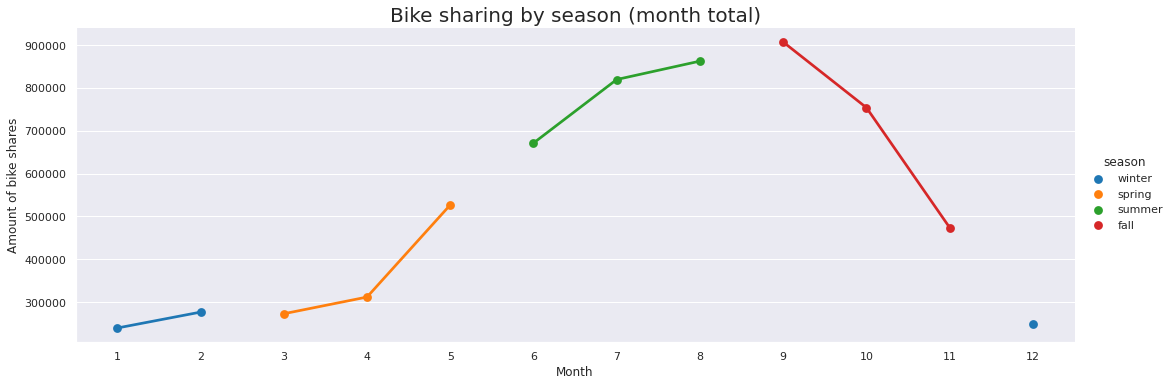

In [58]:
bb_trip_se = bb_trip_hr.groupby('month').agg({'count': 'sum', 'season': 'first'}).reset_index()
sns_plot = sns.catplot(x='month', y='count', hue='season', kind='point', data=bb_trip_se, height=5, aspect=3, palette='tab10');
plt.xlabel('Month');
plt.ylabel('Amount of bike shares');
plt.title('Bike sharing by season (month total)', fontsize=20);
#sns_plot.savefig("Bike sharing by season (month total).png")

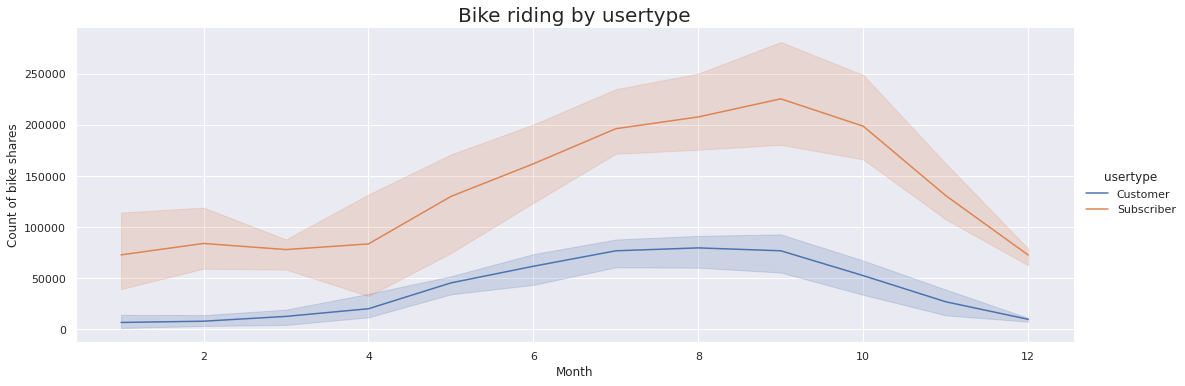

In [59]:
bb_trip_user_se = bb_trip.set_index('starttime').groupby('usertype').resample('M').count()
bb_trip_user_se = bb_trip_user_se[['bikeid']].rename({'bikeid': 'count'}, axis=1).reset_index()
sns_plot = sns.relplot(x=bb_trip_user_se.starttime.dt.month, y='count', hue='usertype', kind='line', data=bb_trip_user_se, height=5, aspect=3);
plt.xlabel('Month')
plt.ylabel('Count of bike shares');
plt.title('Bike riding by usertype', fontsize=20);
#sns_plot.savefig("Bike riding by usertype.png")

### d. Amount of bike shares in a week

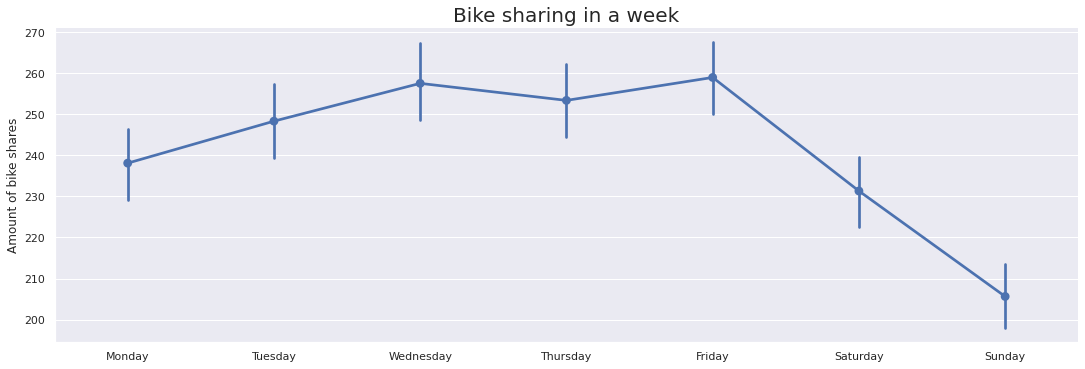

In [60]:
sns_plot = sns.catplot(x='dayofweek', y='count', kind='point', data=bb_trip_hr, height=5, aspect=3);
plt.xticks([0,1,2,3,4,5,6], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday'])
plt.xlabel(None);
plt.ylabel('Amount of bike shares');
plt.title('Bike sharing in a week', fontsize=20);
#sns_plot.savefig("Bike sharing in a week.png")

Once we observed historical macro trends and their possible correlations with the seasonality of service and weather, we continued to move forward with our usage analysis during the week to give us more significant insights on possible patterns.

We plotted the number of bike shares and the days of the week. During the week, we see an average of 190 to 260 bike-share rides per day, with clear peaks on Wednesdays and Fridays, with a significant decrease of demand on Sunday, possibly suggesting that most of our users use this method of transportation during the workdays instead of the weekend. 

Just as demand fluctuates seasonally, BLUEbikes market demand also fluctuates throughout the week. Higher demand is seen during weekdays and, in particular, at the middle of the week.


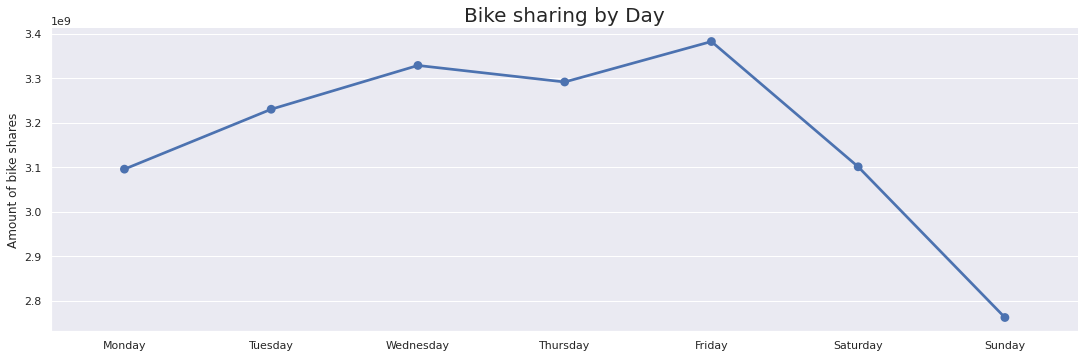

In [61]:
bb_trip_w = bb_trip.groupby(['startdayofweek']).agg({'bikeid': 'sum'}).reset_index().rename({'bikeid': 'count'}, axis=1)

sns_plot = sns.catplot(x='startdayofweek', y='count', kind='point', data=bb_trip_w, height=5, aspect=3);
plt.xticks([0,1,2,3,4,5,6], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']);
plt.ylabel('Amount of bike shares');
plt.xlabel(None)
plt.title('Bike sharing by Day', fontsize=20);
#sns_plot.savefig("Bike sharing by Day.png")

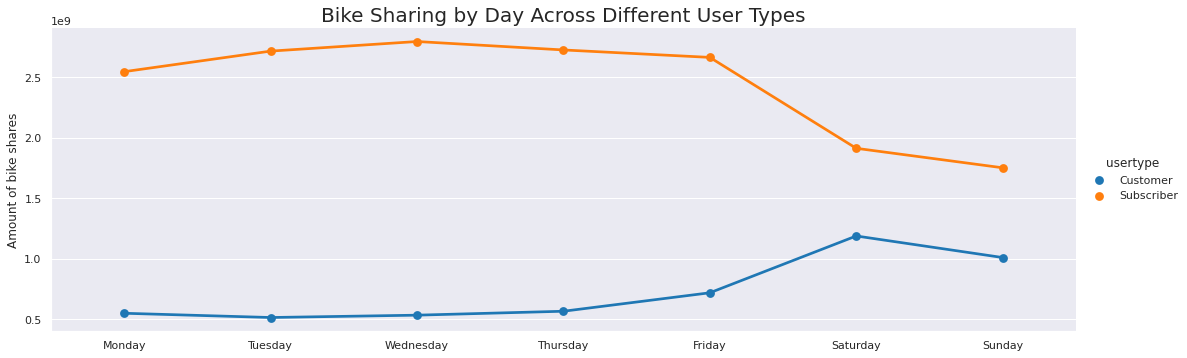

In [62]:
bb_trip_w = bb_trip.groupby(['usertype', 'startdayofweek']).agg({'bikeid': 'sum'}).reset_index().rename({'bikeid': 'count'}, axis=1)

sns_plot = sns.catplot(x='startdayofweek', y='count', hue='usertype', kind='point', data=bb_trip_w, height=5, aspect=3, palette='tab10');
plt.xticks([0,1,2,3,4,5,6], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']);
plt.xlabel(None);
plt.ylabel('Amount of bike shares');
plt.title('Bike Sharing by Day Across Different User Types', fontsize=20);
#sns_plot.savefig("Bike Sharing by Day Across Different User Types.png")

### e. Amount of bike shares in a day


* Amount of bike shares in a weekday

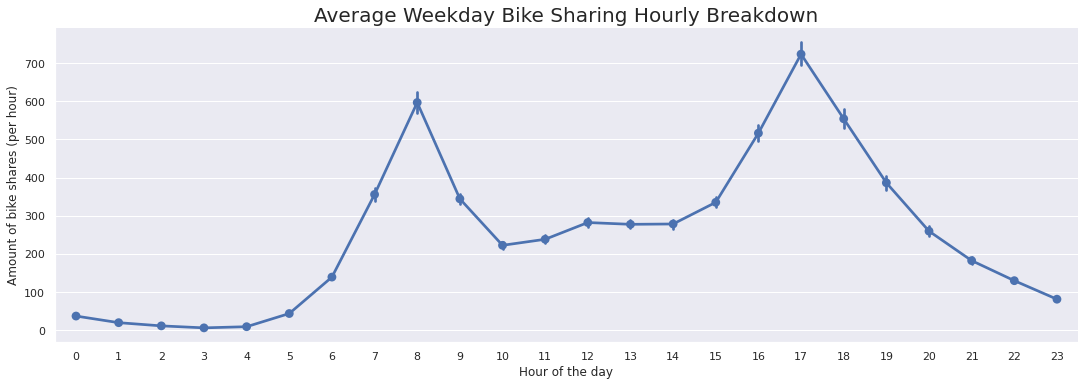

In [63]:
sns_plot = sns.catplot(x='hour', y='count', kind='point', data=bb_trip_hr[bb_trip_hr['dayofweek'].isin([0, 1, 2, 3, 4])], height=5, aspect=3);
plt.xlabel('Hour of the day');
plt.ylabel('Amount of bike shares (per hour)');
plt.title('Average Weekday Bike Sharing Hourly Breakdown', fontsize=20);
#sns_plot.savefig("Average Weekday Bike Sharing Hourly Breakdown.png")


Once we got a deeper understanding of usage by the days of the week, our next step is to visualize usage trends intra-day during the workdays. There's low demand close to zero during the night's hours from midnight to 5 am, when the market starts to surge and peaks at 8 am coinciding with rush-hour, where transportation is limited. The peak is followed by a decrease in usage to almost stable levels around 10 am to 3 pm, right before reaching the highest demand of the day in the evening rush-hour at 5 pm.

The intuition is that customer demand is clearly accelerated in the morning and evening rush hours.


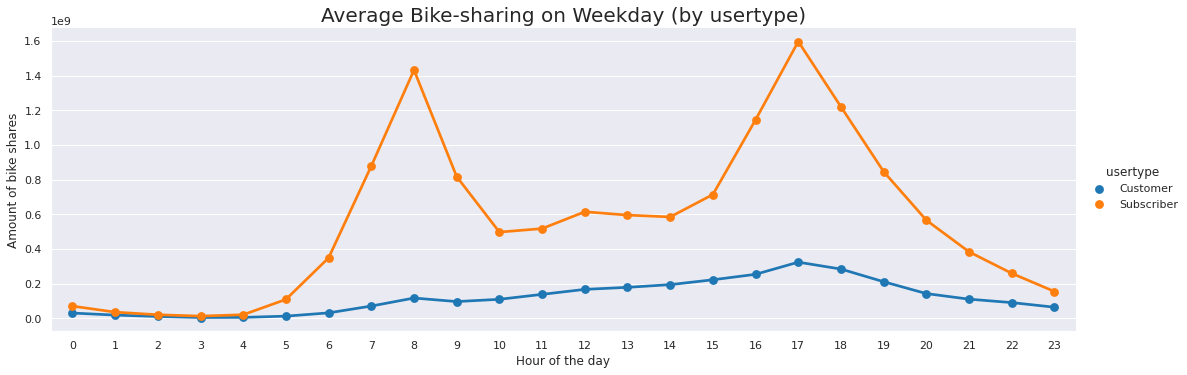

In [64]:
bb_trip_h = bb_trip[bb_trip['startdayofweek'].isin([0, 1, 2, 3, 4])].groupby(['usertype', 'starthour']).agg({'bikeid': 'sum'}).reset_index().rename({'bikeid': 'count'}, axis=1)

sns_plot = sns.catplot(x='starthour', y='count', hue='usertype', kind='point', data=bb_trip_h, height=5, aspect=3, palette='tab10');
plt.xlabel('Hour of the day');
plt.ylabel('Amount of bike shares');
plt.title('Average Bike-sharing on Weekday (by usertype)', fontsize=20);
#sns_plot.savefig("Average Bike-sharing on Weekday (by usertype).png")

* Amount of bike shares in a weekend day

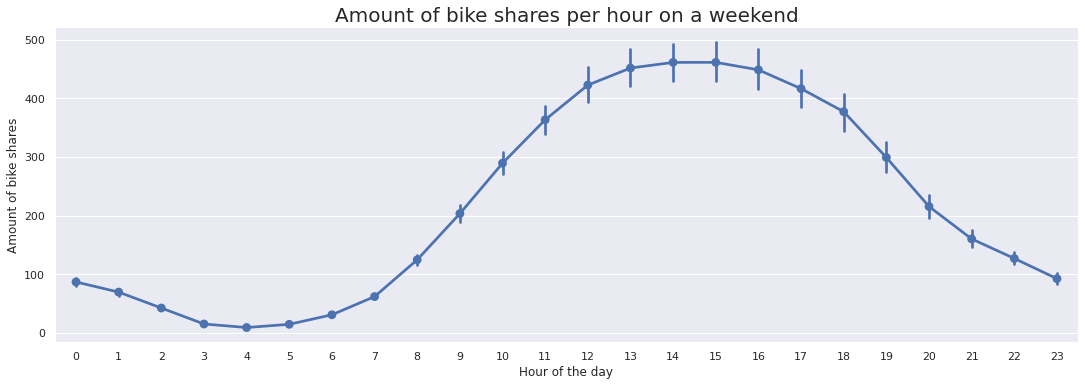

In [65]:
sns_plot = sns.catplot(x='hour', y='count', kind='point', data=bb_trip_hr[bb_trip_hr['dayofweek'].isin([5, 6])], height=5, aspect=3);
plt.xlabel('Hour of the day');
plt.ylabel('Amount of bike shares');
plt.title('Amount of bike shares per hour on a weekend', fontsize=20);
#sns_plot.savefig("Amount of bike shares per hour on a weekend.png")


Once we visually assessed the bike-share usage during the workdays and its possible correlations with morning and evening rush-hours, the nets step is to analyze the hourly usage during the weekends. 

We plotted the number of rides per hour and found a low demand from midnight to 7 am with a steady increase of usage from 8 am, with peak usage from noon to 5 pm, when the demand starts declining.

The intuition is that usage per hour patterns are clearly different between workdays and weekends; these differences might account for patterns in customer behaviors and even customer types, indicating two sub-groups: commuters and tourists/leisure riders.

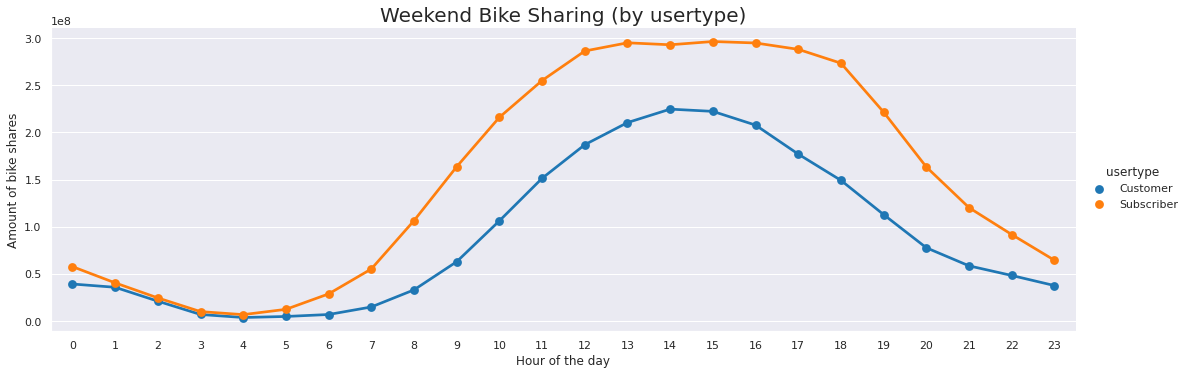

In [66]:
bb_trip_h = bb_trip[bb_trip['startdayofweek'].isin([5, 6])].groupby(['usertype', 'starthour']).agg({'bikeid': 'sum'}).reset_index().rename({'bikeid': 'count'}, axis=1)

sns_plot = sns.catplot(x='starthour', y='count', hue='usertype', kind='point', data=bb_trip_h, height=5, aspect=3, palette='tab10');
plt.xlabel('Hour of the day');
plt.ylabel('Amount of bike shares');
plt.title('Weekend Bike Sharing (by usertype)', fontsize=20);
#sns_plot.savefig("Weekend Bike Sharing (by usertype).png")

### f. Ridership on Holidays

In [67]:
# check holidays
us_holidays = holidays.UnitedStates()                              

bb_trip_hr['holiday_name'] = bb_trip_hr.index
bb_trip_hr['holiday_name'] = bb_trip_hr['holiday_name'].apply(us_holidays.get)
bb_trip_hr['is_holiday'] = bb_trip_hr['holiday_name'].notna()

* Amount of bike sharing during holidays and typical days.

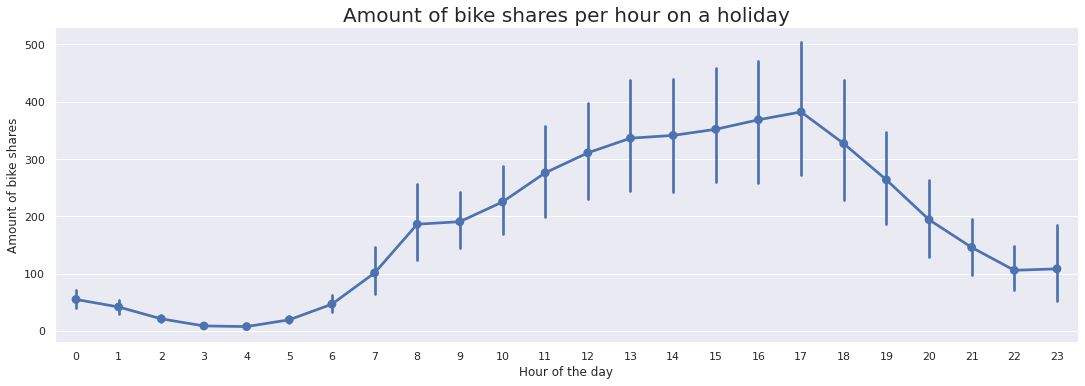

In [68]:
sns_plot = sns.catplot(x='hour', y='count', kind='point', data=bb_trip_hr[bb_trip_hr['is_holiday']], height=5, aspect=3);
plt.title('Amount of bike shares per hour on a holiday', fontsize=20);
plt.xlabel('Hour of the day');
plt.ylabel('Amount of bike shares');
#sns_plot.savefig("Amount of bike shares per hour on a holiday.png")


Our previous analysis observed differences in usage patterns possibly associated with either customer behavior during the week or different types of customers: commuters and tourists or perhaps subscribers and non-subscribers. 

To further evaluate these trends, we analyzed the amount of bike-share rides per hour during the holidays; we see a clear correlation of usage between weekends and holidays.



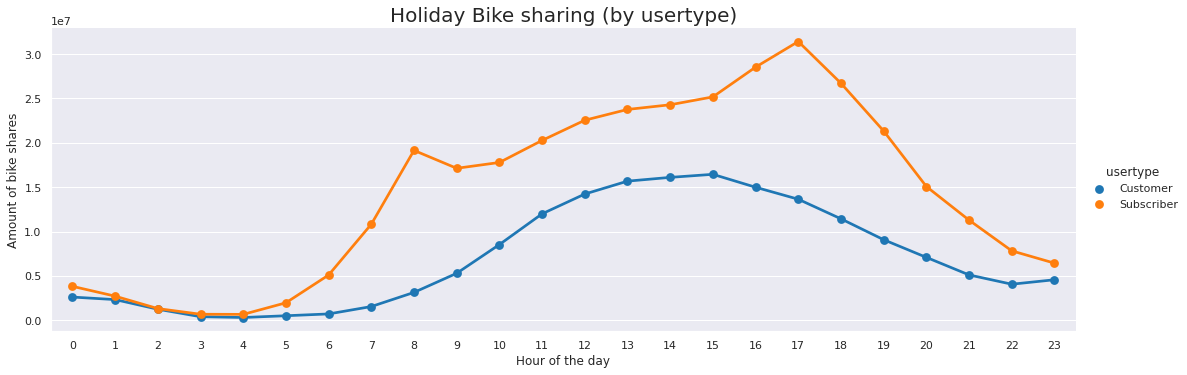

In [69]:
bb_trip_h = bb_trip[bb_trip['is_holiday']].groupby(['usertype', 'starthour']).agg({'bikeid': 'sum'}).reset_index().rename({'bikeid': 'count'}, axis=1)

sns_plot = sns.catplot(x='starthour', y='count', hue='usertype', kind='point', data=bb_trip_h, height=5, aspect=3, palette='tab10');
plt.xlabel('Hour of the day');
plt.ylabel('Amount of bike shares');
plt.title('Holiday Bike sharing (by usertype)', fontsize=20);
#sns_plot.savefig("Holiday Bike sharing (by usertype).png")

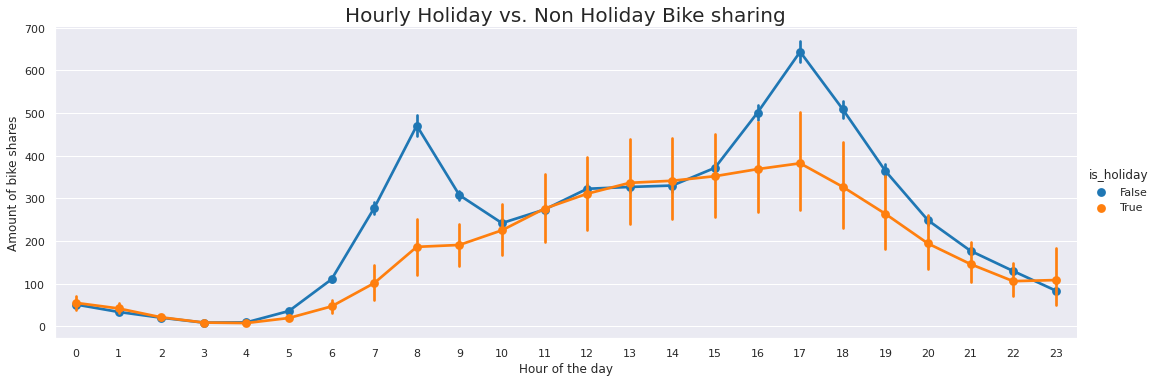

In [70]:
sns_plot = sns.catplot(x='hour', y='count', kind='point', hue='is_holiday', data=bb_trip_hr, height=5, aspect=3, palette='tab10');
plt.xlabel('Hour of the day');
plt.ylabel('Amount of bike shares');
plt.title('Hourly Holiday vs. Non Holiday Bike sharing', fontsize=20);
#sns_plot.savefig("Hourly Holiday vs. Non Holiday Bike sharing.png")


We previously documented a correlation of usage per hour between holidays and weekends. To confirm our previous assumptions, we plotted the number of rides per hour during holidays and non-holidays. 

The intuition confirms that the consumer trends variate between holidays and workdays, once more indicating the existence of different consumer types.

In [71]:
pd.options.display.float_format = '{:.0f}'.format
bb_sec = bb_trip.agg({'tripduration': ['mean', 'median', 'min', 'max']}) 
bb_minute = bb_sec/60
bb_minute

,tripduration
mean,32
median,12
min,1
max,709452


### 2.2.2 Ridership By User Type

Once we plotted and generate theories around consumer usage, we move forward to understand critical metrics on the bike share trip.

We can indicate that the average trip duration is about 30 minutes, with a median of 12 minutes. We can draw an association with the BLUEbikes business model of charging additional fees after 15 minutes of use.

We also want to understand why the minimum trip duration is 61 seconds or about 1 minute to determine whether more short trips like this are associated with a bike malfunction that indicates a problem easily approachable with data analysis.

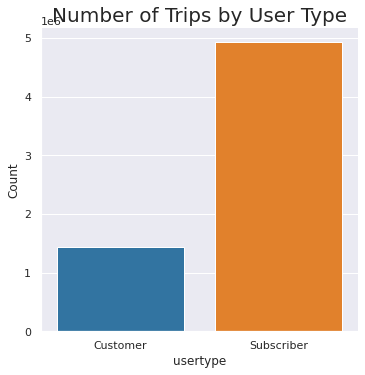

In [116]:
by_usertype = bb_trip.groupby('usertype').agg({'usertype': 'first', 'tripduration': 'mean', 'bikeid': 'count'})
sns_plot = sns.catplot(x='usertype', y='bikeid', kind='bar', data=by_usertype, palette='tab10', height=5, aspect=1);
plt.ylabel('Count');
# plt.xticks(np.arange(3), labels=['Unknown', 'Male', 'Female']);
plt.title('Number of Trips by User Type', fontsize=20);
#sns_plot.savefig("Number of Trips by User Type.png")

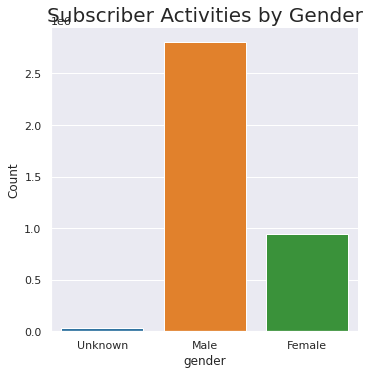

In [114]:
bb_trip['age'] = 2021 - bb_trip['birth year'] 
bb_subscriber = bb_trip[bb_trip.usertype == 'Subscriber']
by_gender = bb_subscriber.groupby('gender').agg({'gender': 'mean', 'tripduration': 'mean', 'bikeid': 'count'})
sns_plot = sns.catplot(x='gender', y='bikeid', kind='bar', data=by_gender, palette='tab10', height=5, aspect=1);
plt.ylabel('Count');
plt.xticks(np.arange(3), labels=['Unknown', 'Male', 'Female']);
plt.title('Subscriber Activities by Gender', fontsize=20);
sns_plot.savefig("Subscriber Activities by Gender.png")

To further understand BLUEbikes customer demographics, we plotted a histogram of genders. We can appreciate that male use of bike ride-sharing is almost three times more prevalent than female use. We also see that some of the database inputs weren't specified, which can be explained by the data collection method with one-time costumers who decide not to share their data.

### 2.2.3 Geographical Analysis

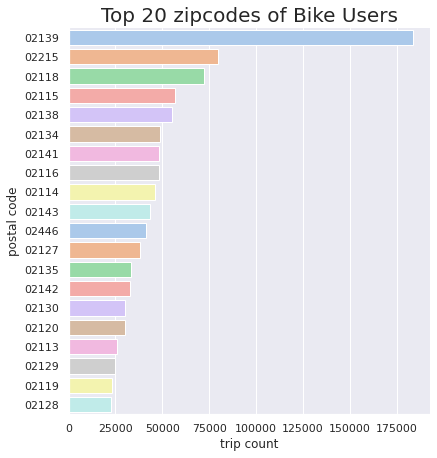

In [117]:
by_zip_code = bb_trip.groupby('postal code').agg({'postal code': 'first', 'bikeid': 'count'})
by_zip_code.rename({'bikeid': 'trip count'}, axis=1, inplace=True)
by_zip_code = by_zip_code.sort_values('trip count', ascending=False)
by_zip_top_20 = by_zip_code.iloc[:20, :]
sns_plot = sns.catplot(y='postal code', x='trip count', palette='pastel', kind='bar', data=by_zip_top_20, height=6, aspect=1);
plt.title('Top 20 zipcodes of Bike Users', fontsize=20);
#sns_plot.savefig("Top 20 zipcodes of Bike Users.png")

This histogram shows the amount of bikes available by zip code. The area with the most significant ridership is 02139, which can be associated with BLUEbikes' close relationship with the city of Cambridge. Mid Cambridge has a considerable student population from MIT, and it's where main MBTA stations like Central Station and The Port are located.

### a. Most used starting stations

In [76]:
most_used_starting_stations = bb_trip.groupby('start station name')[['start station name']].count()
most_used_starting_stations.columns = ['n_used']
most_used_starting_stations = most_used_starting_stations.sort_values('n_used', ascending=False)
most_used_starting_stations = most_used_starting_stations.head(10)

We can mapping this stations on the Boston map to get deeper insights.

#### b. Most used ending stations

In [77]:
most_used_ending_stations = bb_trip.groupby('end station name')[['end station name']].count()
most_used_ending_stations.columns = ['n_used']
most_used_ending_stations = most_used_ending_stations.sort_values('n_used', ascending=False)
most_used_ending_stations = most_used_ending_stations.head(10)

In [78]:
bb_station.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Number       365 non-null    object 
 1   Name         365 non-null    object 
 2   Latitude     365 non-null    float64
 3   Longitude    365 non-null    float64
 4   District     362 non-null    object 
 5   Public       365 non-null    object 
 6   Total docks  365 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 20.1+ KB


Geometrical mapping of above analysis

In [79]:
pip install geopandas -q

     |████████████████████████████████| 1.0MB 13.8MB/s 
     |████████████████████████████████| 6.5MB 43.1MB/s 
     |████████████████████████████████| 15.3MB 331kB/s 


In [80]:
import geopandas

geo_data_drive = "/content/gdrive/Shareddrives/IS833_Team 7/data/geo_data"

# Boston boundary
boston_geo_file = 'City_of_Boston_Boundary.geojson'
boston_geo = '/'.join([geo_data_drive, boston_geo_file])

#universities in Boston
univ_geo_file = 'Colleges_and_Universities.geojson'
univ_geo = '/'.join([geo_data_drive, univ_geo_file])

# zip codes in Boston
# zip_geo_file = 'ZIP_Codes.geojson'
zip_geo_file = 'ma_massachusetts_zip_codes_geo.min.json'
zip_geo = '/'.join([geo_data_drive, zip_geo_file])

# station geo data creation
geometry = geopandas.points_from_xy(bb_station.Longitude, bb_station.Latitude)
station_geo = geopandas.GeoDataFrame(bb_station[['Number', 'Name', 'Latitude', 'Longitude', 'District', 'Public',
       'Total docks']], geometry=geometry)

In [81]:
station_geo.head()

,Number,Name,Latitude,Longitude,District,Public,Total docks,geometry
0,W32006,160 Arsenal,42,-71,Watertown,Yes,11,POINT (-71.17569 42.36466)
1,A32019,175 N Harvard St,42,-71,Boston,Yes,18,POINT (-71.12916 42.36380)
2,S32035,191 Beacon St,42,-71,Somerville,Yes,19,POINT (-71.10879 42.38032)
3,C32094,2 Hummingbird Lane at Olmsted Green,42,-71,Boston,Yes,17,POINT (-71.09500 42.28887)
4,S32023,30 Dane St,42,-71,Somerville,Yes,15,POINT (-71.10403 42.38100)


In [82]:
boston = geopandas.read_file(boston_geo)
boston['area'] = boston.area
boston.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


,OBJECTID,BOSTON_LAN,CITY,COUNTY,SHAPESTArea,SHAPESTLength,geometry,area
0,1,1,,,1346516231,816365,"MULTIPOLYGON (((-71.19083 42.28332, -71.19083 ...",0


In [83]:
zip = geopandas.read_file(zip_geo)
zip['area'] = zip.area
zip.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,area
0,25,02536,2502536,B5,G6350,S,71696166,9066635,+41.5969756,-070.5678768,N,"POLYGON ((-70.59239 41.56006, -70.59268 41.559...",0
1,25,02556,2502556,B5,G6350,S,10034104,1164445,+41.6394454,-070.6245149,N,"POLYGON ((-70.62389 41.61673, -70.62633 41.617...",0
2,25,02540,2502540,B5,G6350,S,27746696,4550024,+41.5741900,-070.6282848,N,"POLYGON ((-70.62389 41.61673, -70.62262 41.616...",0
3,25,02646,2502646,B5,G6350,S,7798581,801405,+41.6705961,-070.0714493,N,"POLYGON ((-70.07925 41.67769, -70.07864 41.677...",0
4,25,01237,2501237,B5,G6350,S,160121626,1140685,+42.5478177,-073.2680327,N,"POLYGON ((-73.23558 42.49333, -73.23587 42.493...",0


/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:642: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:642: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/geopandas/pl

(42.22, 42.43)

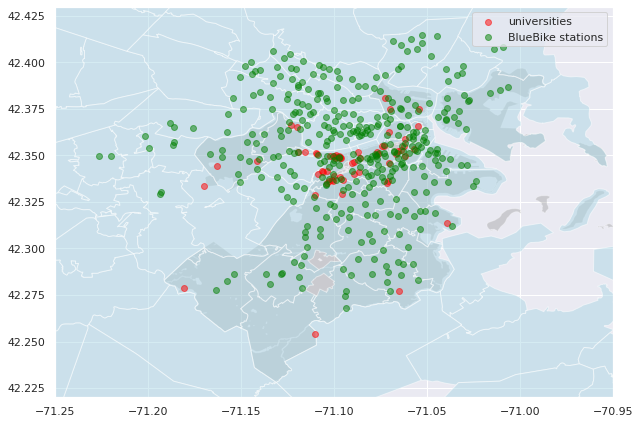

In [84]:
sns.set(rc={'figure.figsize': (10, 10)})
ax = boston.plot('area', color='gray', alpha=0.3, label='Boston area');

zips = geopandas.read_file(zip_geo)
zips['area'] = zip.centroid
zips.plot('area', ax=ax, color='lightblue', alpha=0.5, label='zip code');

univs = geopandas.read_file(univ_geo)
univs['centroid'] = univs.centroid
univs.plot('centroid', ax=ax, color='red', alpha=0.5, label='universities');

stations = station_geo
stations['centroid'] = stations.centroid
stations.plot('centroid', ax=ax, color='green', alpha=0.5, label='BlueBike stations')

plt.legend(loc='upper right')
minx, miny, maxx, maxy = zips.total_bounds

# ax.set_xlim(minx, maxx)
# ax.set_ylim(miny, maxy)

# zoom map
ax.set_xlim(-71.25, -70.95)
ax.set_ylim(42.22, 42.43)

Visualizing the distribution of the most popular BLUEbikes stations and their usage, we see an apparent concentration in the Cambridge area, possibly correlated to local policies of cycling promotion: such as bike lanes, bike facilities, shared lane markings, bicycle parking zoning areas, etc.

We also see an aggregation of bicycles clustered around universities since it is a convenient, reliable, sustainable transportation method for students. We could dive deeper by integrating MBTA stations databased to assess the current hypothesis that most of the BLUEbikes stations are near MBTA stations or near universities to facilitate access to customers.

In [85]:
geo_top_10_starting_stations = stations[stations['Name'].isin(most_used_starting_stations.index)]
geo_top_10_starting_stations

,Number,Name,Latitude,Longitude,District,Public,Total docks,geometry,centroid
20,M32037,Ames St at Main St,42,-71,Cambridge,Yes,19,POINT (-71.08822 42.36250),POINT (-71.08822 42.36250)
80,M32011,Central Square at Mass Ave / Essex St,42,-71,Cambridge,Yes,19,POINT (-71.10310 42.36507),POINT (-71.10310 42.36507)
172,M32018,Harvard Square at Mass Ave/ Dunster,42,-71,Cambridge,Yes,19,POINT (-71.11858 42.37327),POINT (-71.11858 42.37327)
199,M32004,Kendall T,42,-71,Cambridge,Yes,23,POINT (-71.08495 42.36243),POINT (-71.08495 42.36243)
228,M32006,MIT at Mass Ave / Amherst St,42,-71,Cambridge,Yes,27,POINT (-71.09320 42.35810),POINT (-71.09320 42.35810)
231,M32041,MIT Pacific St at Purrington St,42,-71,Cambridge,Yes,19,POINT (-71.10129 42.35957),POINT (-71.10129 42.35957)
232,M32005,MIT Stata Center at Vassar St / Main St,42,-71,Cambridge,Yes,35,POINT (-71.09116 42.36213),POINT (-71.09116 42.36213)
233,M32042,MIT Vassar St,42,-71,Cambridge,Yes,25,POINT (-71.10394 42.35560),POINT (-71.10394 42.35560)
240,A32025,Nashua Street at Red Auerbach Way,42,-71,Boston,Yes,37,POINT (-71.06426 42.36567),POINT (-71.06426 42.36567)
294,A32010,South Station - 700 Atlantic Ave,42,-71,Boston,Yes,47,POINT (-71.05555 42.35218),POINT (-71.05555 42.35218)


Our analysis found an apparent aggregation of the most used docking station and their geographical location, most of them being located in the Cambridge area. We earlier discussed the incentives developed by the city of Cambridge to increase the use of sustainable transportation systems like bicycles. 

In our research, we also found a possible causal effect. In response to the covid-19 pandemic, the city of Cambridge announced the availability of free BLUEbikes passes to essential workers employed at grocery stores, pharmacies, restaurants, and local retail shops. The pass holders were able to take as many trips as they liked during 90 days boosting the utilization of BLUEbikes in this area.

In [86]:
geo_top_10_ending_stations = stations[stations['Name'].isin(most_used_ending_stations.index)]
geo_top_10_ending_stations

,Number,Name,Latitude,Longitude,District,Public,Total docks,geometry,centroid
20,M32037,Ames St at Main St,42,-71,Cambridge,Yes,19,POINT (-71.08822 42.36250),POINT (-71.08822 42.36250)
80,M32011,Central Square at Mass Ave / Essex St,42,-71,Cambridge,Yes,19,POINT (-71.10310 42.36507),POINT (-71.10310 42.36507)
95,B32005,Christian Science Plaza - Massachusetts Ave at...,42,-71,Boston,Yes,19,POINT (-71.08582 42.34367),POINT (-71.08582 42.34367)
172,M32018,Harvard Square at Mass Ave/ Dunster,42,-71,Cambridge,Yes,19,POINT (-71.11858 42.37327),POINT (-71.11858 42.37327)
199,M32004,Kendall T,42,-71,Cambridge,Yes,23,POINT (-71.08495 42.36243),POINT (-71.08495 42.36243)
228,M32006,MIT at Mass Ave / Amherst St,42,-71,Cambridge,Yes,27,POINT (-71.09320 42.35810),POINT (-71.09320 42.35810)
231,M32041,MIT Pacific St at Purrington St,42,-71,Cambridge,Yes,19,POINT (-71.10129 42.35957),POINT (-71.10129 42.35957)
232,M32005,MIT Stata Center at Vassar St / Main St,42,-71,Cambridge,Yes,35,POINT (-71.09116 42.36213),POINT (-71.09116 42.36213)
240,A32025,Nashua Street at Red Auerbach Way,42,-71,Boston,Yes,37,POINT (-71.06426 42.36567),POINT (-71.06426 42.36567)
294,A32010,South Station - 700 Atlantic Ave,42,-71,Boston,Yes,47,POINT (-71.05555 42.35218),POINT (-71.05555 42.35218)


/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:642: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:642: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:642: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:642: UserWarning: Only specify one of 'column' or 'color'. U

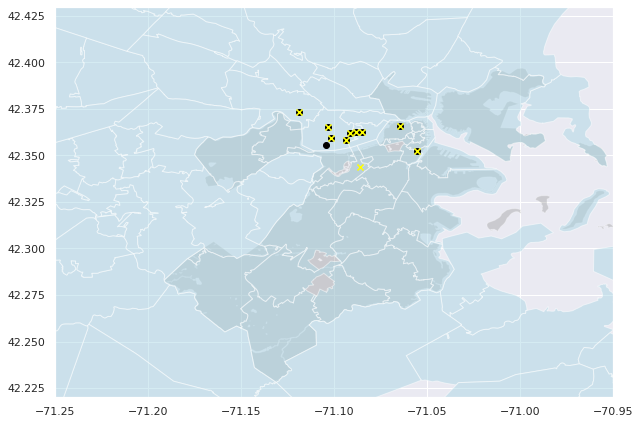

In [87]:
sns.set(rc={'figure.figsize': (10, 10)})
ax = boston.plot('area', color='gray', alpha=0.3);

zips = geopandas.read_file(zip_geo)
zips['area'] = univs.centroid
zips.plot('area', ax=ax, color='lightblue', alpha=0.5);

geo_top_10_starting_stations.plot('centroid', ax=ax, color='black', marker='o');

geo_top_10_ending_stations.plot('centroid', ax=ax, color='yellow', marker='x');

# ax.set_xlim(minx, maxx)
# ax.set_ylim(miny, maxy)

# zoom map
ax.set_xlim(-71.25, -70.95);
ax.set_ylim(42.22, 42.43);

As we can observe in the map 9 stations of 11 stations are overlap as a top starting and ending stations.
We can focus on these 11 stations to find the need to expand the bike stock.
Daily usage data for each 11 stations. we can visualize the bike stock by hour this can easily reveal the needs or overflow of bike stock.

# **3. Bike Malfunction Analysis**




A major problem for BLUEbikes services is the issue of bicycle mal performance detection, upkeep, and maintenance; in this analysis, we test the problem of early identification of non-functioning bicycles and propose possible key optimization checkpoints for transportation maintenance. 

Bluebikes bicycles are checked in the field 1-2 times a month to ensure they are safe and are operating in top condition. The cleaning schedule for stations and kiosks follows the cleaning schedule for the adjacent street. Stations are also frequently visited by station techs for routine maintenance. 

On the website, BLUEbikes suggested that 'if there is a problem with the bike, please stop riding the bike and dock it at the nearest station and press the button on the dock with a wrench symbol on it. This will turn the light on the dock red so no one else can use the bike before our technicians can fix it.' 

Firstly, we want to check if users would use this wrench button when encountering a malfunction bike, and further examine if the usertype would matter in this situation. 


We define a 'trouble' situation as `tripduration` <= 180 seconds, `'start station id'` == `'end station id'` - which means the rider started and ended at the same station with 3 minutes ; and 
a 'nearby' situation as `tripduration` <= 180 seconds, '`start station id`' != '`end station id`':

In [88]:
#define bb_min as all trip less than 180 seconds
bb_min = bb_act[bb_act.tripduration <= 180]
print('usertype:', bb_min.usertype.unique())
bb_customer_min = bb_min[bb_min.usertype == 'Customer']
bb_subscriber_min = bb_min[bb_min.usertype == 'Subscriber']

#define trouble situation as tripduration <= 180 seconds, 'start station id' == 'end station id'
bb_trouble = bb_min[bb_min['start station id'] == bb_min['end station id']]
#define nearby situation as tripduration <= 180 seconds, 'start station id' != 'end station id'
bb_nearby = bb_min[bb_min['start station id'] != bb_min['end station id']]

#We can check the distribution of the data to see if data cleaning is needed:
#sns.scatterplot(data=bb_trouble, x='start station id', y='end station id', hue='usertype')
#sns.scatterplot(data=bb_nearby, x='start station id', y='end station id', hue='usertype')


usertype: ['Subscriber' 'Customer']



We calculate the possiblity a customer type of the user (non-subscriber) would encounter a malfunction bike versus the possibility a subscriber would encounter a malfunction bike 



In [89]:
broken_rate_s = bb_trouble.bikeid[bb_trouble.usertype == 'Subscriber'].count() / bb_trip.bikeid[bb_trip.usertype == 'Subscriber'].count()
broken_rate_c = bb_trouble.bikeid[bb_trouble.usertype == 'Customer'].count() / bb_trip.bikeid[bb_trip.usertype == 'Customer'].count()
print('the possiblity a customer type of the user (non-subscriber) would encounter a malfunction bike:', round(broken_rate_s,4)*100, '%')
print('the possiblity a subscriber would encounter a malfunction bike:', round(broken_rate_c,4)*100, '%')


the possiblity a customer type of the user (non-subscriber) would encounter a malfunction bike: 0.36 %
the possiblity a subscriber would encounter a malfunction bike: 0.48 %


This shows the possibility any rider would encounter a malfunction bike would be similar no matter the person is a subscriber or not; however, the possibility a subscriber would encounter is a little bit less than a customer as the subscriber might use their familiar bike stations more frequently or they have more experience to detect a malfunction bike before using the service.



---
Then we calculate the possibility a customer type of the user (non-subscriber) would use BLUEbikes services for a nearby trip versus would use BLUEbikes services for a nearby trip:


In [90]:
nearby_rate_s = bb_nearby.bikeid[bb_nearby.usertype == 'Subscriber'].count() / bb_trip.bikeid[bb_trip.usertype == 'Subscriber'].count()
nearby_rate_c = bb_nearby.bikeid[bb_nearby.usertype == 'Customer'].count() / bb_trip.bikeid[bb_trip.usertype == 'Customer'].count()
print('the possiblity a subscriber would use BLUEbikes services for a nearby trip:', round(nearby_rate_s,4)*100, '%')
print('the possiblity a customer would use BLUEbikes services for a nearby trip:', round(nearby_rate_c,4)*100, '%')


the possiblity a subscriber would use BLUEbikes services for a nearby trip: 3.34 %
the possiblity a customer would use BLUEbikes services for a nearby trip: 0.25 %


This shows much more subscribers (3.34\%) would use BLUEbikes services for a nearby trip than random customers (0.25\%), which is very reasonable since subscribers benefit from their monthly or yearly membership.


Then we calculate how many riding activities in general, and how many malfunction bike situations happened:

In [104]:
print('how many activities in general?')
print('In general, subscribers have used BLUEbikes', bb_trip.bikeid[bb_trip.usertype == 'Subscriber'].count(),'times.')     
print('Random customers have used BLUEbikes',bb_trip.bikeid[bb_trip.usertype == 'Customer'].count(),'times.')

print('how many malfunction bike situations happened?')
bb_troubleid = bb_trouble.bikeid.unique()

print(bb_trouble.bikeid.count(), 'malfunction bike situations have happened,',len(bb_trouble.bikeid.unique()),'numbers of bikes are related' )

print('On average, the same broken bike is likely to be rerented', round(bb_trouble.bikeid.count() / len(bb_trouble.bikeid.unique()),4), 'before removed from service for repair')


how many activities in general?
In general, subscribers have used BLUEbikes 4928224 times.
Random customers have used BLUEbikes 1435801 times.
how many malfunction bike situations happened?
24767 malfunction bike situations have happened, 5123 numbers of bikes are related
On average, the same broken bike is likely to be rerented 4.8345 before removed from service for repair


Now we want to identify if users would use this wrench button when encountering a malfunction bike, how BLUEbike can optimize their maintenance system. 

In [92]:
#creat the list of all routes of bikes
bb_track = bb_act[bb_act.bikeid.isin(bb_troubleid)].sort_values(by=['bikeid','starttime'])

In [93]:
#sort malfunction situations by 'bikeid' and'starttime'
bb_trouble = bb_trouble.sort_values(by=['bikeid','starttime'])

We assume a 'troublemaker' bike for BLUEbikes is the bikes that encounter at least 5 malfunction situations, and we examine consecutive malfunction bb_extreme situations (which means a bike was encountering at least 2 malfunction situations at the same station). 

In [94]:
#tm = troublemaker
bb_tm = bb_trouble.loc[bb_trouble.groupby('bikeid')['bikeid'].transform('size') >= 5]

bb_tm = bb_tm.loc[bb_tm.groupby(['bikeid','start station id'])['start station id'].transform('size') >= 2]
#bb_tm.to_csv('bb_tm.csv')
bb_extreme = bb_tm.loc[bb_tm.groupby(['bikeid','start station id'])['start station id'].transform('size') >= 4]
#bb_extreme.to_csv('bb_extreme.csv')

This bb_extreme list would help BLUEbikes further examine malfunction situations and optimize maintenance services.

We notice that sometimes it took BLUEbikes more than 7 days to take an malfunction bike away from the situation, for example, bike 2981, were tried to be used 7 times from 2019-7-5 to 2019 -7-11 before got fixed, and the most recently malfunction situation happened in 2020-8-2. 

**We recommend BLUEbikes optimize the advertising material for its wrench button function. And BLUEbikes should consider self-alarm system for the maintenance team with algorithm such as if a bike encounter 2 times malfunction situation at the same station, maintenance worker should get alarmed.**



#**4. Station Dock Optimization**

We assume that at 4:00 am all the bike station's dock is filled with bike. From there we can analyze the utilization of each station.
We will analyze most used starting stations' bike stock for the past 3 years (2018 - 2020). From there, we will find stations to add more dock.
Or we can find under-utilized stations and dispatch less bike than number of dock at that station.

In [95]:
# show most used starting stations
most_used_starting_stations

,n_used
start station name,
MIT at Mass Ave / Amherst St,144203
Central Square at Mass Ave / Essex St,122563
MIT Stata Center at Vassar St / Main St,108995
South Station - 700 Atlantic Ave,93564
MIT Pacific St at Purrington St,86874
Ames St at Main St,85044
Nashua Street at Red Auerbach Way,84391
Harvard Square at Mass Ave/ Dunster,82207
Kendall T,81502


We will build a dataset by 1 minute sampling for this analysis. Analysis will be performed only on most used starting station because those stations under-stock probability is higher than other stations. Firstly, we build departure count dataset.

In [96]:
# build 1 min aggraration data from original trip data
dep_cnt = bb_trip.set_index('starttime').resample('1Min').agg({'bikeid': 'count', 'start station name': 'first'})
dep_cnt = dep_cnt[dep_cnt['start station name'].notna()]
dep_cnt = dep_cnt.reset_index()
dep_cnt.rename({'bikeid': 'dep_cnt'}, axis=1, inplace=True)
dep_cnt.head()

,starttime,dep_cnt,start station name
0,2018-01-01 00:16:00,1,MIT Pacific St at Purrington St
1,2018-01-01 00:42:00,2,Union Square - Somerville
2,2018-01-01 00:56:00,1,Coolidge Corner - Beacon St @ Centre St
3,2018-01-01 01:07:00,1,Tremont St at E Berkeley St
4,2018-01-01 01:15:00,1,Seaport Hotel - Congress St at Seaport Ln


Build arrive count dataset for most used starting stations.

In [97]:
# arrive bike count
arr_cnt = bb_trip.set_index('stoptime').resample('1Min').agg({'bikeid': 'count', 'end station name': 'first'})
arr_cnt = arr_cnt[arr_cnt['end station name'].notna()]
arr_cnt = arr_cnt.reset_index()
arr_cnt.rename({'bikeid': 'arr_cnt'}, axis=1, inplace=True)
arr_cnt.head()

,stoptime,arr_cnt,end station name
0,2018-01-01 00:23:00,1,Ames St at Main St
1,2018-01-01 00:46:00,1,Cambridge Dept. of Public Works -147 Hampshire...
2,2018-01-01 01:02:00,1,Central Sq Post Office / Cambridge City Hall a...
3,2018-01-01 01:11:00,1,University Park
4,2018-01-01 01:16:00,1,Christian Science Plaza - Massachusetts Ave at...


Aggregate dataset by station and timestamp, resulting in bike count change:


In [98]:
# aggregate data for each station
dep_cnt_s = dep_cnt.groupby(['start station name', 'starttime']).count()*-1
dep_cnt_s = dep_cnt_s.reset_index()

arr_cnt_s = arr_cnt.groupby(['end station name', 'stoptime']).count()
arr_cnt_s = arr_cnt_s.reset_index()

# concaternate aggregated data
bike_stock = pd.DataFrame(np.concatenate((dep_cnt_s.values, arr_cnt_s.values), axis=0))
bike_stock.columns = ['station', 'timestamp', 'cnt']
bike_stock.head()

,station,timestamp,cnt
0,175 N Harvard St,2018-01-02 12:33:00,-1
1,175 N Harvard St,2018-01-02 15:41:00,-1
2,175 N Harvard St,2018-01-02 16:25:00,-1
3,175 N Harvard St,2018-01-03 19:01:00,-1
4,175 N Harvard St,2018-01-03 20:51:00,-1


Set up necessary function for calculating minimum stock for each day and ploting.
1. `get_stock_data`: will generate estimated stock data within a specific datedata(`bs_sub`)
    * `bs_sub`: bike data of specific date. We will use this dataframe for estimating bike stock status.
    * `n_dock`: number of docks at the station
    * `st_name`: name of station
2. `get_min_stock`: return the minimum stock of the date
    * `bs_sub`: bike data of specific date. We will use this dataframe for estimating bike stock status.
    * `n_dock`: number of docks at the station
    * `st_name`: name of station
3. `draw_stock`: not used here


In [99]:
def get_stock_data(bs_sub, n_dock, st_name):
    #print('get_stock_data')
    result = bs_sub.reset_index()
    try:
        b_refill = result.iloc[0, :].copy()
        #b_refill = result[0]

        ref_day = '/'.join([str(b_refill['timestamp'].year), str(b_refill['timestamp'].month), str(b_refill['timestamp'].day)])
        ref_time = '04:01:00'

        ref_timestamp = ' '.join([ref_day, ref_time])

        b_refill['timestamp'] = dt.strptime(ref_timestamp, '%Y/%m/%d %H:%M:%S')
        b_refill['cnt'] = n_dock

        result = result.append(b_refill)
    except IndexError:
        pass

    result = result.sort_values('timestamp', ascending=True)

    # cumsum after 4:00 am
    result = result[result['timestamp'].dt.hour >= 4].copy()
    result['cnt'] = result['cnt'].cumsum()

    result.reset_index()

    # adjust over dock count data
    while any(result['cnt'] > n_dock):
        chg_aft = result.loc[result['cnt'] > n_dock, 'cnt'].index[0]
        #chg_aft
        result.loc[result.index >= chg_aft, 'cnt'] = result.loc[result.index >= chg_aft, 'cnt'] - 1
    return result

def get_min_stock(bs_sub, n_dock, st_name):
    #print('get_stoget_min_stockck_data')
    result = get_stock_data(bs_sub, n_dock, st_name)
    # print(result)
    return result['cnt'].min()

def draw_stock(bs_sub, n_dock, st_name):
    #print('draw_stock')
    result = get_stock_data(bs_sub, n_dock, st_name)

    # draw chart
    sns.relplot(x='timestamp', y='cnt', data=result, kind='line', height=2, aspect=2);
    plt.title(st_name)
    plt.ylim(0, n_dock + 1);
    plt.xticks(rotation=60);
    return None

In [100]:
stock_period = pd.to_datetime('2020-12-31') - pd.to_datetime('2018-01-01')
stock_period = int(stock_period.days)

For each station, we calculated minimum stock for each day and plot it. (it takes around 4 minutes to execute)

In [101]:
bike_stock.isna().sum()

station      0
timestamp    0
cnt          0
dtype: int64

>>> station: MIT at Mass Ave / Amherst St is processing ... 
>>> station: Central Square at Mass Ave / Essex St is processing ... 
>>> station: MIT Stata Center at Vassar St / Main St is processing ... 
>>> station: South Station - 700 Atlantic Ave is processing ... 
>>> station: MIT Pacific St at Purrington St is processing ... 
>>> station: Ames St at Main St is processing ... 
>>> station: Nashua Street at Red Auerbach Way is processing ... 
>>> station: Harvard Square at Mass Ave/ Dunster is processing ... 
>>> station: Kendall T is processing ... 
>>> station: MIT Vassar St is processing ... 


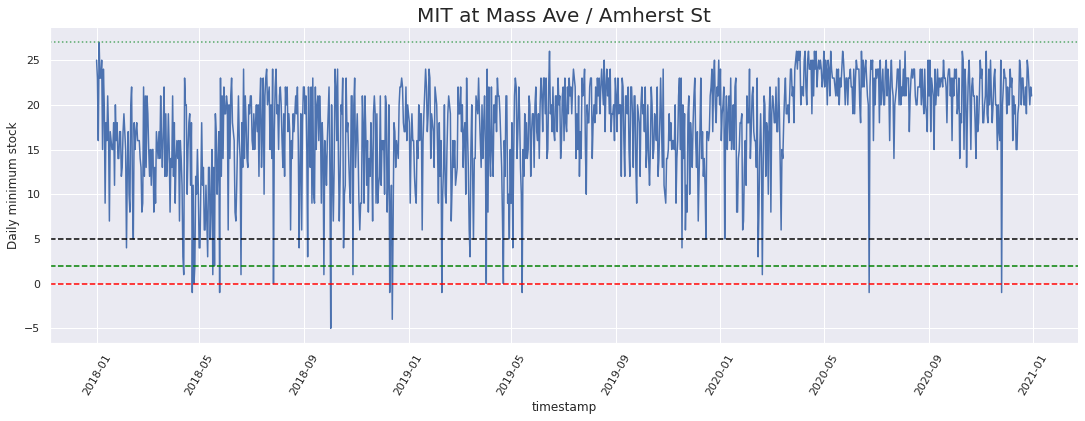

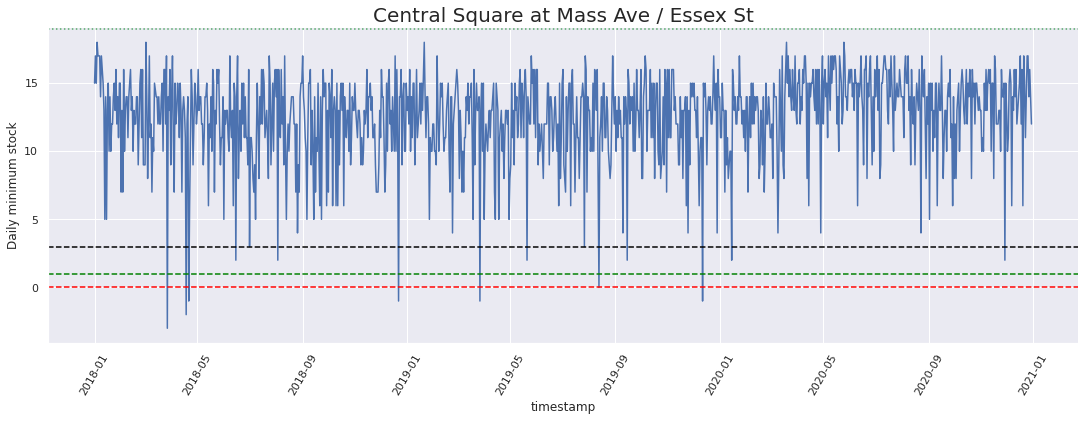

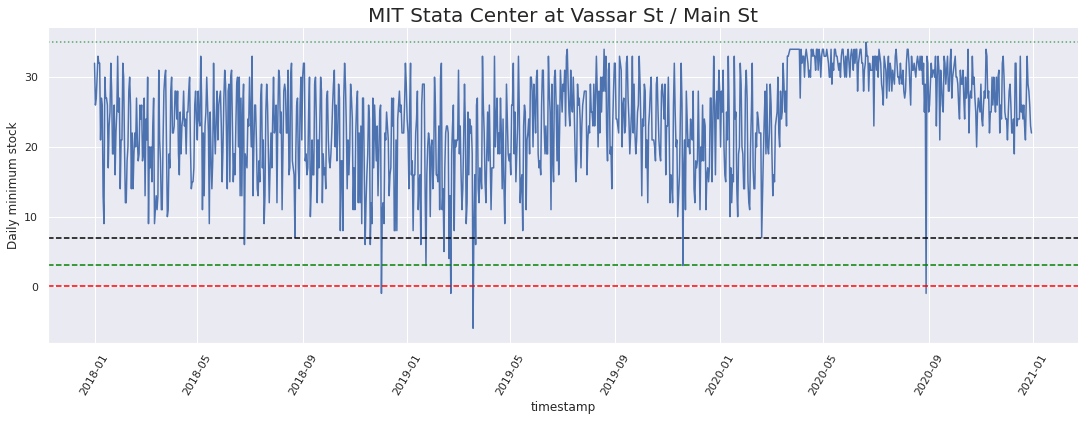

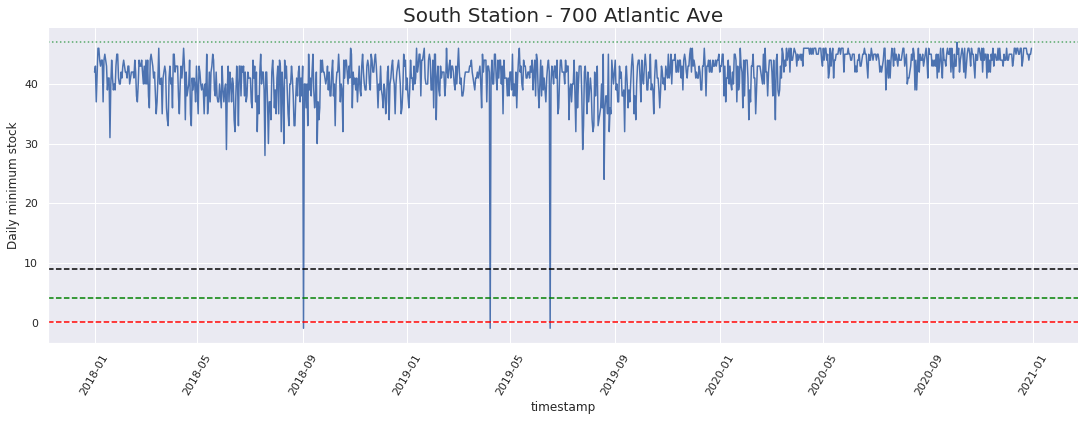

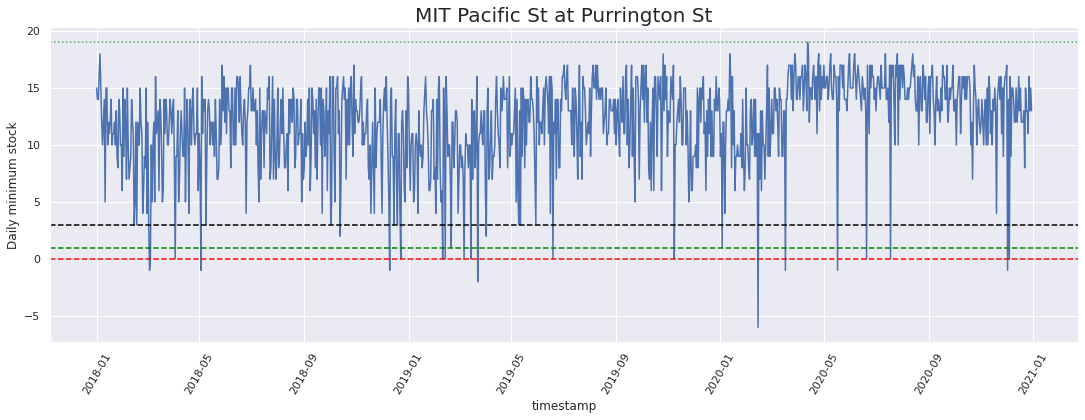

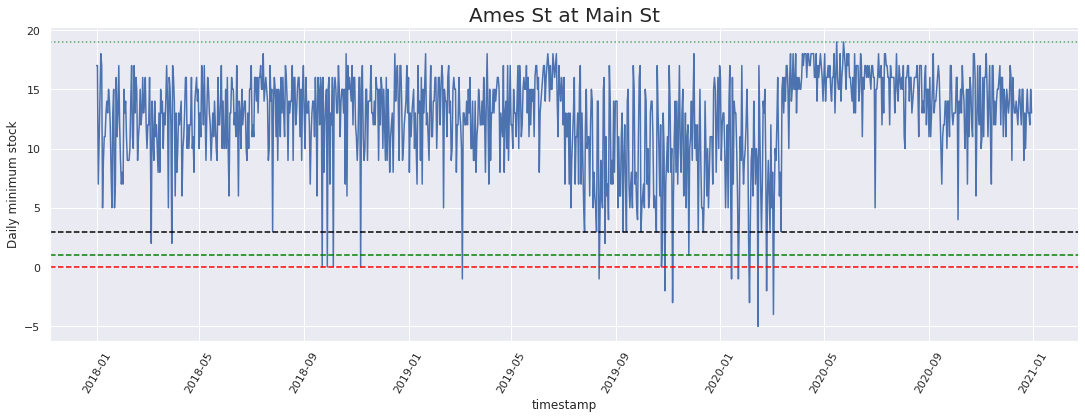

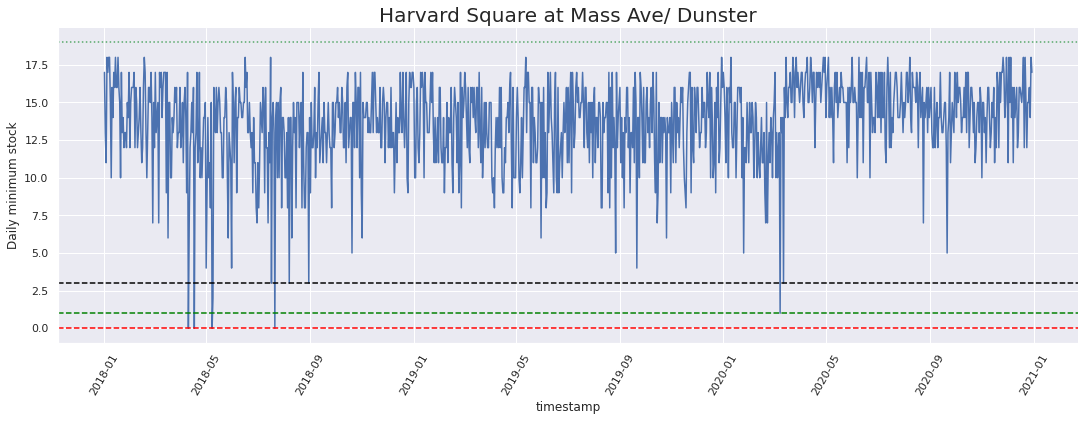

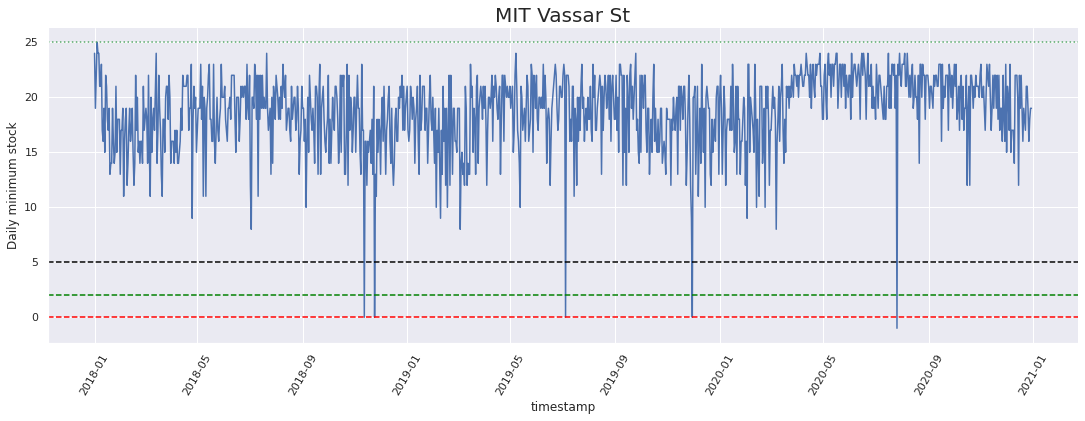

In [102]:
for st_name in most_used_starting_stations.index:
    print('>>> station: {0} is processing ... '.format(st_name))
    try:
        bs = bike_stock.loc[bike_stock['station'] == st_name, :].groupby(['station', 'timestamp']).agg({'cnt': 'sum'})

        bs = bs.reset_index()
        bs = bs.set_index('timestamp')
        base = '2018-01-01'
        stock_date = pd.date_range(dt.strptime(base, '%Y-%m-%d'), periods=stock_period).tolist()
        daily_stock = pd.DataFrame(np.empty([stock_period, 4], dtype=str)).copy()
        daily_stock.columns = ['timestamp', 'station', 'min', 'n_dock']
        idx = 0

        for d in stock_date:
            bs_sub = bs[str(d.date())].copy()

            n_dock = int(bb_station.loc[bb_station['Name'] == st_name, 'Total docks'].copy())

            a = get_min_stock(bs_sub, n_dock, st_name)    
        
            e = np.array([d, st_name, a, n_dock]).copy()
            daily_stock.iloc[idx, :] = e.copy()
            idx += 1
                    
        # drop rows with 'min' is na
        daily_stock = daily_stock[daily_stock['min'].notna()].copy()
        daily_stock.loc[:, 'timestamp'] = daily_stock['timestamp'].copy().astype('datetime64', copy=True)
        daily_stock.loc[:, 'min'] = daily_stock['min'].copy().astype('int', copy=True)
        daily_stock.loc[:, 'n_dock'] = daily_stock['n_dock'].copy().astype('int', copy=True)
        
        # draw chart
        sns.relplot(x='timestamp', y='min', kind='line', data=daily_stock, height=5, aspect=3);
        plt.axhline(y=n_dock, linestyle=':', color='g')
        plt.axhline(y=0, linestyle='--', color='red')
        plt.axhline(y=int(n_dock * 0.1), linestyle='--', color='green')
        plt.axhline(y=int(n_dock * 0.2), linestyle='--', color='black')
        plt.xticks(rotation=60);
        plt.title(daily_stock['station'][0], fontsize=20);
        plt.ylabel('Daily minimum stock')
            
    except KeyError:
        pass

The dotted lines are stock out level for 100% (red), 90% (green), 80% (black) of number of docks. By visual inspection of each station. As we can see there are some periods that the bike stock drops under 0. We can find the following three stations needs further research:

*   **MIT at Mass Ave/Amherst St**
*   **MIT Packfic St at Purrington St**
*   **Ames St at Main St**

We can go further data exploration by dive into the days and hours of each under stock period. We can refill bike by transporting from under used station. This optimization will help BLUEbikes to catch all the possible bike sharing trip that might have been lost due to under stock of bike.

*Note: there was Key Error during the processing of two stations, 'Nashua Street at Red Auerbach Way' and 'Kendall T'. This is caused by the missing of some date data.

#**5. Reflection and Further Analysis**

We also consider how we would dig further in these directions: 

* We can correlate our current ridership data to weather data such as precipitation, snow, humidity, and temperature.

* To optimize routes and docking station utilization we can do a cluster analysis by peak rush hour in the mornings and evenings.

* What are the top stations people choose to go nearby/short trips?

* For malfunction bikes, is there a greater prevalence of broken bikes at certain stations, or are broken bikes evenly or randomly distributed? 

* How's the stock utilization rate of those stations we identified? 

